# Offline RL (80 Points)

> Name: Pouya Lahabi

> SID: 400109843




In this notebook, we will implement the Soft Actor Critic (SAC) algorithm on the CartPole environment in both online and offline settings. The SAC framework focuses on maximizing the expected reward while also maximizing entropy, meaning the actor aims to succeed at the task while maintaining a high level of randomness in its actions. This approach explicitly encourages exploration by seeking a high entropy in the policy.

In the second part, we will use the policy learned in the first part to collect a dataset of expert trajectories and perform behavioral cloning.

*The existing results are the baseline for the quality of your implementation.*

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal
import torch.optim as optim
import numpy as np
import random
import gym
import matplotlib.pyplot as plt
import imageio
from tqdm import tqdm


seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [2]:
from IPython.display import HTML
from base64 import b64encode

def show_video(path):
    mp4 = open(path, 'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    return HTML("""
    <video width=400 controls>
          <source src="%s" type="video/mp4">
    </video>
    """ % data_url)

## Network Structure (10 points)
For constructing SAC agent, we use objects of feedforward neural networks with 3 layers. Complete the code below.

In [21]:
class Network(torch.nn.Module):

    def __init__(self, input_dimension, output_dimension, output_activation=torch.nn.Identity(), hidden_dimension = 64):
        super(Network, self).__init__()
        ##########################################################
        
        # Define network layers
        ##########################################################

        self.fc1 = nn.Linear(input_dimension, hidden_dimension)
        self.fc2 = nn.Linear(hidden_dimension, hidden_dimension)
        self.fc3 = nn.Linear(hidden_dimension, output_dimension)
        self.output_activation = output_activation

    def forward(self, inpt):
        output = None
        ##########################################################
        
        # Calculate the output
        ##########################################################
        x = F.relu(self.fc1(inpt))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        output = self.output_activation(x)
        return output

## Replay Buffer

A SAC agent requires a replay buffer to sample previously visited states. You can utilize the implemented code below to set up this replay buffer.

In [22]:
import numpy as np

class ReplayBuffer:

    def __init__(self, environment, capacity=500000):
        transition_type_str = self.get_transition_type_str(environment)
        self.buffer = np.zeros(capacity, dtype=transition_type_str)
        self.weights = np.zeros(capacity)
        self.head_idx = 0
        self.count = 0
        self.capacity = capacity
        self.max_weight = 1e-2
        self.delta = 1e-4
        self.indices = None
        self.mirror_index = np.random.permutation(range(self.buffer.shape[0]))

    def get_transition_type_str(self, environment):
        state_dim = environment.observation_space.shape[0]
        state_dim_str = '' if state_dim == () else str(state_dim)
        state_type_str = environment.observation_space.sample().dtype.name
        action_dim = environment.action_space.shape
        action_dim_str = '' if action_dim == () else str(action_dim)
        action_type_str = environment.action_space.sample().__class__.__name__

        transition_type_str = '{0}{1}, {2}{3}, float32, {0}{1}, float32'.format(state_dim_str, state_type_str,
                                                                             action_dim_str, action_type_str)

        return transition_type_str

    def add_transition(self, transition):
        self.buffer[self.head_idx] = transition
        self.weights[self.head_idx] = self.max_weight

        self.head_idx = (self.head_idx + 1) % self.capacity
        self.count = min(self.count + 1, self.capacity)

    def sample_minibatch(self, size=100, batch_deterministic_start=None):
        set_weights = self.weights[:self.count] + self.delta
        probabilities = set_weights / sum(set_weights)
        if batch_deterministic_start is None:
            self.indices = np.random.choice(range(self.count), size, p=probabilities, replace=False)
        else:
            self.indices = self.mirror_index[batch_deterministic_start:batch_deterministic_start+size]
        return self.buffer[self.indices]

    def update_weights(self, prediction_errors):
        max_error = max(prediction_errors)
        self.max_weight = max(self.max_weight, max_error)
        self.weights[self.indices] = prediction_errors

    def get_size(self):
        return self.count

## SAC Agent (50 points)

Now complete the following class. You can use the auxiliary methods provided in the class.




In [29]:
class SACAgent:
    def __init__(self, environment, replay_buffer=None, offline=False, learning_rate=3e-3, discount=0.99, buffer_batch_size=100, alpha_init=1, interpolation_factor=0.01):
        self.environment = environment
        self.state_dim = self.environment.observation_space.shape[0]
        self.action_dim = self.environment.action_space.n

        self.alpha_init = alpha_init
        self.learning_rate = learning_rate
        self.discount = discount
        self.buffer_batch_size = buffer_batch_size
        self.interpolation_factor = interpolation_factor

        self.replay_buffer = ReplayBuffer(self.environment) if replay_buffer is None else replay_buffer
        self.offline = offline

        ##########################################################
        
        # Define critics usig implemented feed forward netwrok
        ##########################################################
        self.critic_local = Network(self.state_dim, 1)
        self.critic_local2 = Network(self.state_dim, 1)
        self.critic_target = Network(self.state_dim, 1)
        self.critic_target2 = Network(self.state_dim, 1)

        self.critic_optimiser = torch.optim.Adam(self.critic_local.parameters(), lr=self.learning_rate)
        self.critic_optimiser2 = torch.optim.Adam(self.critic_local2.parameters(), lr=self.learning_rate)
        ##########################################################

        self.soft_update_target_networks(tau=1.)

        ##########################################################
        
        # Define the actor
        # Define the actor optimizer
        ##########################################################
        self.actor_local = Network(self.state_dim, self.action_dim, output_activation=torch.nn.Softmax(dim=-1))
        self.actor_optimiser = torch.optim.Adam(self.actor_local.parameters(), lr=self.learning_rate)
        ##########################################################
        self.target_entropy = 0.98 * -np.log(1 / self.environment.action_space.n)
        self.log_alpha = torch.tensor(np.log(self.alpha_init), requires_grad=True)
        self.alpha = self.log_alpha
        self.alpha_optimiser = torch.optim.Adam([self.log_alpha], lr=self.learning_rate)

    def get_next_action(self, state, evaluation_episode=False):
        if evaluation_episode:
            discrete_action = self.get_action_deterministically(state)
        else:
            discrete_action = self.get_action_nondeterministically(state)
        return discrete_action

    def get_action_nondeterministically(self, state):
        action_probabilities = self.get_action_probabilities(state)
        discrete_action = np.random.choice(range(self.action_dim), p=action_probabilities)
        return discrete_action

    def get_action_deterministically(self, state):
        action_probabilities = self.get_action_probabilities(state)
        discrete_action = np.argmax(action_probabilities)
        return discrete_action

    def critic_loss(self, states_tensor, actions_tensor, rewards_tensor,
                    next_states_tensor, done_tensor):
        ##########################################################
        
        # calculate critic losses
        ##########################################################
        next_action_probs, next_log_action_probs = self.get_action_info(states_tensor)
        next_log_action_probs = next_log_action_probs.gather(1, actions_tensor.unsqueeze(1)).view(-1)

        next_q1 = self.critic_target(next_states_tensor).view(-1)
        next_q2 = self.critic_target2(next_states_tensor).view(-1)

        next_q = torch.min(next_q1, next_q2) - self.alpha * next_log_action_probs
        target_q = rewards_tensor + self.discount * (1 - done_tensor) * next_q

        current_q1 = self.critic_local(states_tensor).view(-1)
        current_q2 = self.critic_local2(states_tensor).view(-1)

        critic_loss1 = F.mse_loss(current_q1, target_q)
        critic_loss2 = F.mse_loss(current_q2, target_q)

        return critic_loss1, critic_loss2
        ##########################################################

    def actor_loss(self, states_tensor, actions_tensor):
        ##########################################################
        
        # Implement the actor loss
        ##########################################################
        action_probabilities, log_action_probabilities = self.get_action_info(states_tensor)

        log_action_probabilities = log_action_probabilities.gather(1, actions_tensor.unsqueeze(1)).view(-1)

        q1 = self.critic_local(states_tensor)
        q2 = self.critic_local2(states_tensor)
        q = torch.min(q1, q2).view(-1)

        actor_loss = (self.alpha * log_action_probabilities - q).mean()

        return actor_loss, log_action_probabilities
        ##########################################################

    def train_on_transition(self, state, discrete_action, next_state, reward, done):
        transition = (state, discrete_action, reward, next_state, done)
        self.train_networks(transition)

    def train_networks(self, transition=None, batch_deterministic_start=None):
        ##########################################################
        
        # Set all the gradients stored in the optimizers to zero
        # Add the new transition to the replay buffer for online case
        ##########################################################
        self.critic_optimiser.zero_grad()
        self.critic_optimiser2.zero_grad()
        self.actor_optimiser.zero_grad()
        self.alpha_optimiser.zero_grad()

        if transition is not None and not self.offline:
            self.replay_buffer.add_transition(transition)

        if self.replay_buffer.get_size() >= self.buffer_batch_size:
            minibatch = self.replay_buffer.sample_minibatch(self.buffer_batch_size, batch_deterministic_start=batch_deterministic_start)
            minibatch_separated = list(map(list, zip(*minibatch)))

            states_tensor = torch.tensor(np.array(minibatch_separated[0]))
            actions_tensor = torch.tensor(np.array(minibatch_separated[1]))
            rewards_tensor = torch.tensor(np.array(minibatch_separated[2])).float()
            next_states_tensor = torch.tensor(np.array(minibatch_separated[3]))
            done_tensor = torch.tensor(np.array(minibatch_separated[4]))


            ##########################################################
            
            # compute the critic loss and perform the backpropagation,
            # compute the actor loss and backpropagate the gradient
            # update \alpha
            ##########################################################

            critic_loss1, critic_loss2 = self.critic_loss(states_tensor, actions_tensor, rewards_tensor, next_states_tensor, done_tensor)
            critic_loss1.backward(retain_graph = True)
            critic_loss2.backward(retain_graph = True)
            self.critic_optimiser.step()
            self.critic_optimiser2.step()

            actor_loss, log_action_probabilities = self.actor_loss(states_tensor, actions_tensor)
            actor_loss.backward()
            self.actor_optimiser.step()

            alpha_loss = self.temperature_loss(log_action_probabilities)
            alpha_loss.backward()
            self.alpha_optimiser.step()

            self.alpha = self.log_alpha.exp()

            self.soft_update_target_networks(self.interpolation_factor)

    def temperature_loss(self, log_action_probabilities):
        alpha_loss = -(self.log_alpha * (log_action_probabilities + self.target_entropy).detach()).mean()
        return alpha_loss

    def get_action_info(self, states_tensor):
        action_probabilities = self.actor_local.forward(states_tensor)
        z = action_probabilities == 0.0
        z = z.float() * 1e-8
        log_action_probabilities = torch.log(action_probabilities + z)
        return action_probabilities, log_action_probabilities

    def get_action_probabilities(self, state):
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        action_probabilities = self.actor_local.forward(state_tensor)
        if torch.isnan(action_probabilities).any():
          print("NaN values in action_probabilities")
          print(action_probabilities)
        return action_probabilities.squeeze(0).detach().numpy()

    def soft_update_target_networks(self, tau):
        self.soft_update(self.critic_target, self.critic_local, tau)
        self.soft_update(self.critic_target2, self.critic_local2, tau)

    def soft_update(self, target_model, origin_model, tau):
        for target_param, local_param in zip(target_model.parameters(), origin_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1 - tau) * target_param.data)

    def predict_q_values(self, state, action):
        q_values = self.critic_local(state)
        q_values2 = self.critic_local2(state)
        return torch.min(q_values, q_values2)

## Online SAC (10 points)

Now evaluate your model in CartPole environment in the online setting. After each 4 episodes, you should evaluate your model on a separate test environment. Run your model 4 times separately and plot the mean and deviation of the evaluation curves.

**NOTE:** Since you are going to use the replay buffer of this agent as the offline dataset, you may want to save it for later use.

Starting run 1/4


  0%|          | 0/200 [00:00<?, ?it/s]

Episode 0: Evaluation Reward = 14.90


  2%|▎         | 5/200 [00:00<00:10, 19.18it/s]

Episode 4: Evaluation Reward = 9.50


  4%|▍         | 9/200 [00:00<00:17, 10.72it/s]

Episode 8: Evaluation Reward = 9.50


  6%|▋         | 13/200 [00:01<00:27,  6.73it/s]

Episode 12: Evaluation Reward = 18.60


  9%|▉         | 18/200 [00:02<00:40,  4.53it/s]

Episode 16: Evaluation Reward = 26.20


 11%|█         | 22/200 [00:03<00:36,  4.85it/s]

Episode 20: Evaluation Reward = 25.90


 13%|█▎        | 26/200 [00:04<00:33,  5.21it/s]

Episode 24: Evaluation Reward = 61.10


 14%|█▍        | 29/200 [00:05<00:50,  3.39it/s]

Episode 28: Evaluation Reward = 184.10


 17%|█▋        | 34/200 [00:06<00:35,  4.74it/s]

Episode 32: Evaluation Reward = 161.50


 18%|█▊        | 37/200 [00:07<00:40,  3.98it/s]

Episode 36: Evaluation Reward = 145.60


 21%|██        | 42/200 [00:08<00:42,  3.73it/s]

Episode 40: Evaluation Reward = 91.40


 23%|██▎       | 46/200 [00:09<00:40,  3.84it/s]

Episode 44: Evaluation Reward = 164.30


 25%|██▌       | 50/200 [00:10<00:32,  4.57it/s]

Episode 48: Evaluation Reward = 111.90


 27%|██▋       | 54/200 [00:11<00:42,  3.47it/s]

Episode 52: Evaluation Reward = 199.90


 28%|██▊       | 57/200 [00:13<01:02,  2.29it/s]

Episode 56: Evaluation Reward = 200.00


 30%|███       | 61/200 [00:16<01:55,  1.20it/s]

Episode 60: Evaluation Reward = 167.70


 32%|███▎      | 65/200 [00:21<02:48,  1.25s/it]

Episode 64: Evaluation Reward = 200.00


 34%|███▍      | 69/200 [00:28<03:48,  1.74s/it]

Episode 68: Evaluation Reward = 200.00


 36%|███▋      | 73/200 [00:33<03:16,  1.55s/it]

Episode 72: Evaluation Reward = 200.00


 38%|███▊      | 77/200 [00:40<03:24,  1.66s/it]

Episode 76: Evaluation Reward = 200.00


 40%|████      | 81/200 [00:47<03:42,  1.87s/it]

Episode 80: Evaluation Reward = 200.00


 42%|████▎     | 85/200 [00:54<03:34,  1.86s/it]

Episode 84: Evaluation Reward = 200.00


 44%|████▍     | 89/200 [01:02<03:26,  1.86s/it]

Episode 88: Evaluation Reward = 200.00


 46%|████▋     | 93/200 [01:09<03:27,  1.94s/it]

Episode 92: Evaluation Reward = 200.00


 48%|████▊     | 97/200 [01:18<03:31,  2.05s/it]

Episode 96: Evaluation Reward = 200.00


 50%|█████     | 101/200 [01:24<02:47,  1.69s/it]

Episode 100: Evaluation Reward = 200.00


 52%|█████▎    | 105/200 [01:32<03:04,  1.94s/it]

Episode 104: Evaluation Reward = 200.00


 55%|█████▍    | 109/200 [01:40<03:14,  2.13s/it]

Episode 108: Evaluation Reward = 200.00


 56%|█████▋    | 113/200 [01:48<03:09,  2.18s/it]

Episode 112: Evaluation Reward = 200.00


 58%|█████▊    | 117/200 [01:57<02:59,  2.17s/it]

Episode 116: Evaluation Reward = 200.00


 60%|██████    | 121/200 [02:06<02:58,  2.25s/it]

Episode 120: Evaluation Reward = 200.00


 62%|██████▎   | 125/200 [02:13<02:31,  2.02s/it]

Episode 124: Evaluation Reward = 200.00


 64%|██████▍   | 129/200 [02:22<02:28,  2.08s/it]

Episode 128: Evaluation Reward = 200.00


 66%|██████▋   | 133/200 [02:31<02:32,  2.27s/it]

Episode 132: Evaluation Reward = 200.00


 68%|██████▊   | 137/200 [02:40<02:34,  2.46s/it]

Episode 136: Evaluation Reward = 200.00


 70%|███████   | 141/200 [02:50<02:22,  2.41s/it]

Episode 140: Evaluation Reward = 200.00


 72%|███████▎  | 145/200 [02:59<02:07,  2.33s/it]

Episode 144: Evaluation Reward = 200.00


 74%|███████▍  | 149/200 [03:09<02:00,  2.36s/it]

Episode 148: Evaluation Reward = 200.00


 76%|███████▋  | 153/200 [03:18<01:52,  2.40s/it]

Episode 152: Evaluation Reward = 200.00


 78%|███████▊  | 157/200 [03:27<01:48,  2.52s/it]

Episode 156: Evaluation Reward = 200.00


 80%|████████  | 161/200 [03:37<01:32,  2.37s/it]

Episode 160: Evaluation Reward = 200.00


 82%|████████▎ | 165/200 [03:47<01:29,  2.55s/it]

Episode 164: Evaluation Reward = 200.00


 84%|████████▍ | 169/200 [03:57<01:18,  2.52s/it]

Episode 168: Evaluation Reward = 200.00


 86%|████████▋ | 173/200 [04:07<01:09,  2.57s/it]

Episode 172: Evaluation Reward = 200.00


 88%|████████▊ | 177/200 [04:17<01:01,  2.66s/it]

Episode 176: Evaluation Reward = 200.00


 90%|█████████ | 181/200 [04:27<00:49,  2.60s/it]

Episode 180: Evaluation Reward = 200.00


 92%|█████████▎| 185/200 [04:37<00:37,  2.52s/it]

Episode 184: Evaluation Reward = 200.00


 94%|█████████▍| 189/200 [04:48<00:29,  2.71s/it]

Episode 188: Evaluation Reward = 200.00


 96%|█████████▋| 193/200 [04:58<00:18,  2.66s/it]

Episode 192: Evaluation Reward = 200.00


 98%|█████████▊| 197/200 [05:09<00:08,  2.68s/it]

Episode 196: Evaluation Reward = 200.00


100%|██████████| 200/200 [05:17<00:00,  1.59s/it]


Run 1 completed


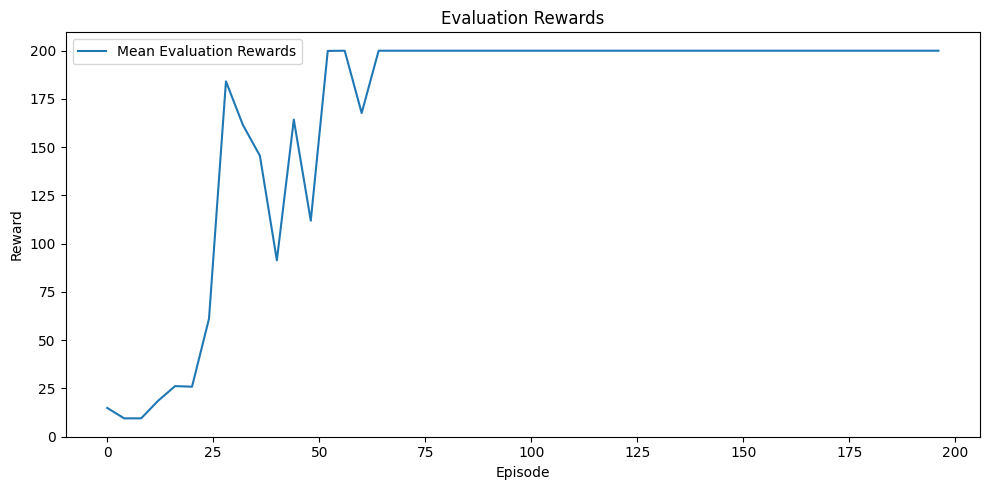

In [33]:
TRAINING_EVALUATION_RATIO = 4
EPISODES_PER_RUN = 200
STEPS_PER_EPISODE = 200
NUM_RUNS = 1

env = gym.make("CartPole-v1")

##########################################################

# Implement the training loop for the online SAC.
# After each epoch, run validation
# and plot the mean return over these
# episodes in the end
# Plot the learning curves
##########################################################

agent = SACAgent(env, learning_rate=5e-3, buffer_batch_size=100)

def run_episode(env, agent, train=True):
    state = env.reset()
    total_reward = 0
    for _ in range(STEPS_PER_EPISODE):
        action = agent.get_next_action(state, evaluation_episode=not train)
        next_state, reward, done, _ = env.step(action)
        if train:
            agent.train_on_transition(state, action, next_state, reward, done)
        total_reward += reward
        state = next_state
        if done:
            break
    return total_reward

training_rewards = []
evaluation_rewards = []

for run in range(NUM_RUNS):
    print(f"Starting run {run + 1}/4")
    run_training_rewards = []
    run_evaluation_rewards = []
    for episode in tqdm(range(EPISODES_PER_RUN)):
        train_reward = run_episode(env, agent, train=True)
        run_training_rewards.append(train_reward)

        if episode % TRAINING_EVALUATION_RATIO == 0:
            eval_rewards = [run_episode(env, agent, train=False) for _ in range(10)]
            mean_eval_reward = np.mean(eval_rewards)
            run_evaluation_rewards.append(mean_eval_reward)
            print(f"Episode {episode}: Evaluation Reward = {mean_eval_reward:.2f}")

    training_rewards.append(run_training_rewards)
    evaluation_rewards.append(run_evaluation_rewards)
    print(f"Run {run + 1} completed")

evaluation_rewards = np.array(evaluation_rewards)

mean_evaluation_rewards = np.mean(evaluation_rewards, axis=0)
std_evaluation_rewards = np.std(evaluation_rewards, axis=0)

## Save the replay buffer to use later
np.save("replay_buffer.npy", agent.replay_buffer.buffer)

plt.figure(figsize=(10, 5))
plt.plot(np.arange(0, EPISODES_PER_RUN, TRAINING_EVALUATION_RATIO), mean_evaluation_rewards, label='Mean Evaluation Rewards')
plt.fill_between(np.arange(0, EPISODES_PER_RUN, TRAINING_EVALUATION_RATIO), mean_evaluation_rewards - std_evaluation_rewards, mean_evaluation_rewards + std_evaluation_rewards, alpha=0.2)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Evaluation Rewards')
plt.legend()
plt.tight_layout()
plt.show()


In [34]:
## Save the replay buffer

online_replay_buffer = agent.replay_buffer

In [35]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
frames = []

state = env.reset()
for _ in range(100):
    frames.append(env.render()[0])
    action = agent.get_next_action(state, evaluation_episode=True)
    state, reward, done, info = env.step(action)
    if done:
        break

env.close()
imageio.mimsave('./online.mp4', frames, fps=25)
show_video('./online.mp4')

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


## Offline SAC (10 points)

In this part you are going to train an SAC agent using the replay buffer from the online agent. During training you sample from this replay buffer and train the offline agent **without adding transitions to the replay buffer**. The loss function and every thing else is the same as the online setting.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Starting run 1/4


  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
  1%|          | 1/100 [00:00<00:35,  2.75it/s]

Episode 0: Evaluation Reward = 15.50


  5%|▌         | 5/100 [00:01<00:23,  3.99it/s]

Episode 4: Evaluation Reward = 9.40


 10%|█         | 10/100 [00:02<00:20,  4.37it/s]

Episode 8: Evaluation Reward = 8.90


 13%|█▎        | 13/100 [00:03<00:18,  4.72it/s]

Episode 12: Evaluation Reward = 9.30


 18%|█▊        | 18/100 [00:04<00:15,  5.37it/s]

Episode 16: Evaluation Reward = 8.80


 21%|██        | 21/100 [00:04<00:19,  4.11it/s]

Episode 20: Evaluation Reward = 9.20


 25%|██▌       | 25/100 [00:05<00:17,  4.19it/s]

Episode 24: Evaluation Reward = 10.40


 30%|███       | 30/100 [00:07<00:18,  3.84it/s]

Episode 28: Evaluation Reward = 11.60


 33%|███▎      | 33/100 [00:08<00:20,  3.32it/s]

Episode 32: Evaluation Reward = 9.40


 37%|███▋      | 37/100 [00:10<00:26,  2.41it/s]

Episode 36: Evaluation Reward = 9.30


 41%|████      | 41/100 [00:11<00:19,  3.07it/s]

Episode 40: Evaluation Reward = 9.50


 45%|████▌     | 45/100 [00:12<00:17,  3.19it/s]

Episode 44: Evaluation Reward = 9.30


 49%|████▉     | 49/100 [00:14<00:28,  1.79it/s]

Episode 48: Evaluation Reward = 9.60


 54%|█████▍    | 54/100 [00:17<00:20,  2.20it/s]

Episode 52: Evaluation Reward = 108.90


 57%|█████▋    | 57/100 [00:19<00:25,  1.66it/s]

Episode 56: Evaluation Reward = 197.60


 61%|██████    | 61/100 [00:23<00:45,  1.16s/it]

Episode 60: Evaluation Reward = 200.00


 65%|██████▌   | 65/100 [00:29<00:52,  1.49s/it]

Episode 64: Evaluation Reward = 200.00


 69%|██████▉   | 69/100 [00:37<00:59,  1.92s/it]

Episode 68: Evaluation Reward = 200.00


 73%|███████▎  | 73/100 [00:48<01:06,  2.48s/it]

Episode 72: Evaluation Reward = 200.00


 77%|███████▋  | 77/100 [00:59<01:01,  2.69s/it]

Episode 76: Evaluation Reward = 200.00


 81%|████████  | 81/100 [01:10<00:52,  2.74s/it]

Episode 80: Evaluation Reward = 200.00


 85%|████████▌ | 85/100 [01:22<00:42,  2.84s/it]

Episode 84: Evaluation Reward = 200.00


 89%|████████▉ | 89/100 [01:33<00:31,  2.83s/it]

Episode 88: Evaluation Reward = 200.00


 93%|█████████▎| 93/100 [01:45<00:19,  2.84s/it]

Episode 92: Evaluation Reward = 200.00


 97%|█████████▋| 97/100 [01:56<00:08,  2.88s/it]

Episode 96: Evaluation Reward = 200.00


100%|██████████| 100/100 [02:02<00:00,  1.23s/it]


Run 1 completed


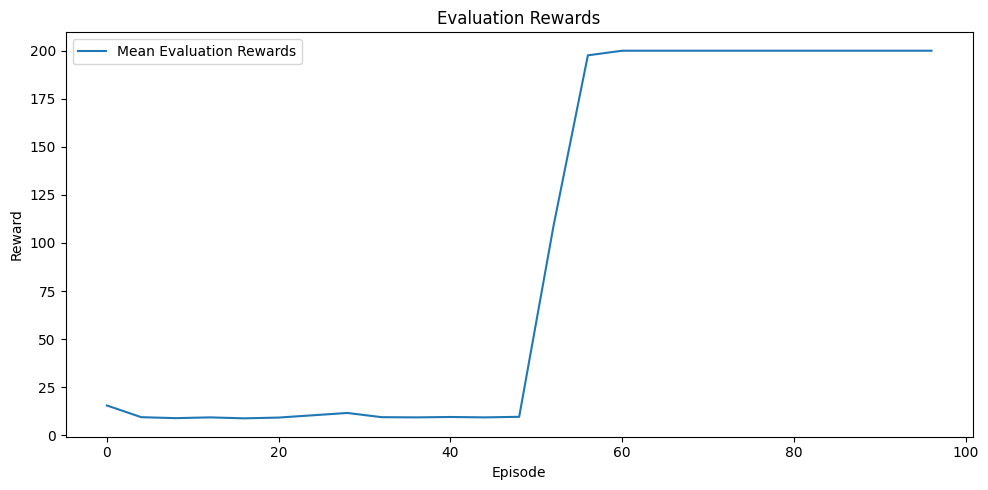

In [36]:
NUM_EPOCHS = 200
EPISODES_PER_RUN = 100
NUM_RUNS = 1

env = gym.make("CartPole-v1")

##########################################################

# Implement the training loop for the offline SAC.
# After each epoch, run  validation
# and plot the mean return over these
# episodes in the end
##########################################################

offline_agent = SACAgent(env, learning_rate=5e-3, buffer_batch_size=100, replay_buffer = online_replay_buffer, offline = True)

training_rewards = []
evaluation_rewards = []

for run in range(NUM_RUNS):
    print(f"Starting run {run + 1}/4")
    run_training_rewards = []
    run_evaluation_rewards = []
    for episode in tqdm(range(EPISODES_PER_RUN)):
    # for episode in range(EPISODES_PER_RUN):
        train_reward = run_episode(env, offline_agent, train=True)
        run_training_rewards.append(train_reward)

        if episode % TRAINING_EVALUATION_RATIO == 0:
            eval_rewards = [run_episode(env, offline_agent, train=False) for _ in range(10)]
            mean_eval_reward = np.mean(eval_rewards)
            run_evaluation_rewards.append(mean_eval_reward)
            print(f"Episode {episode}: Evaluation Reward = {mean_eval_reward:.2f}")

    training_rewards.append(run_training_rewards)
    evaluation_rewards.append(run_evaluation_rewards)
    print(f"Run {run + 1} completed")

evaluation_rewards = np.array(evaluation_rewards)

mean_evaluation_rewards = np.mean(evaluation_rewards, axis=0)
std_evaluation_rewards = np.std(evaluation_rewards, axis=0)


plt.figure(figsize=(10, 5))
plt.plot(np.arange(0, EPISODES_PER_RUN, TRAINING_EVALUATION_RATIO), mean_evaluation_rewards, label='Mean Evaluation Rewards')
plt.fill_between(np.arange(0, EPISODES_PER_RUN, TRAINING_EVALUATION_RATIO), mean_evaluation_rewards - std_evaluation_rewards, mean_evaluation_rewards + std_evaluation_rewards, alpha=0.2)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Evaluation Rewards')
plt.legend()
plt.tight_layout()
plt.show()

In [38]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
frames = []

state = env.reset()
for _ in range(100):
    frames.append(env.render()[0])
    action = offline_agent.get_next_action(state, evaluation_episode=True)
    state, reward, done, info = env.step(action)
    if done:
        break
env.close()
imageio.mimsave('./offline.mp4', frames, fps=25)
show_video('./offline.mp4')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym

 # Behavioural Cloning (20 points)

Behavioral cloning works by mimicking expert behavior through supervised learning. It involves collecting a dataset of expert trajectories, which are sequences of state-action pairs (unlike offline reinforcement learning, which also collects rewards to train the model). The model is then trained to predict the expert's actions based on the observed states. The goal is for the model to replicate the expert's behavior by minimizing the difference between its predicted actions and the expert's actions.

We first need to collect data using the previously trained model.

In [40]:
env = gym.make('CartPole-v1')
num_episodes = 1000
expert_data = []


# Collect state-action pairs
for episode in tqdm(range(num_episodes)):
    done = False
    state = env.reset()
    while not done:
        action = offline_agent.get_next_action(state, evaluation_episode=True)
        next_state, reward, done, info = env.step(action)
        expert_data.append((state, action))
        state = next_state

expert_data = np.array(expert_data, dtype=object)


  0%|          | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|██████████| 1000/1000 [02:00<00:00,  8.31it/s]


In [45]:
# print(expert_data[0][1])

0


Define the model for behaviuoral cloning.

In [46]:
class BCModel(nn.Module):
    def __init__(self, input_dimension, hidden_dimension, output_dimension):
        super(BCModel, self).__init__()
        
        # Define the model
        self.fc1 = nn.Linear(input_dimension, hidden_dimension)
        self.fc2 = nn.Linear(hidden_dimension, output_dimension)

    def forward(self, x):
        
        # Perform forward pass
        x = F.relu(self.fc1(x))
        output = self.fc2(x)
        return output

In this section, we implement the training loop for behavioral cloning. During each iteration, we sample a minibatch of state-action pairs from the expert dataset. This minibatch is then used to update the model.

In [49]:

input_dimension = env.observation_space.shape[0]
hidden_dimension = 64
output_dimension = env.action_space.n

bc_model = BCModel(input_dimension= input_dimension, hidden_dimension= hidden_dimension, output_dimension= output_dimension)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(bc_model.parameters(), lr=1e-3)

num_epochs = 20
batch_size = 32

states = np.array([data[0] for data in expert_data])
actions = np.array([data[1] for data in expert_data])

for epoch in tqdm(range(num_epochs)):
    total_loss = 0
    
    # Implement behavioural cloning training loop

    permutation = np.random.permutation(len(states))
    shuffled_states = states[permutation]
    shuffled_actions = actions[permutation]

    for i in range(0, len(states), batch_size):
        batch_states = torch.tensor(shuffled_states[i:i+batch_size], dtype=torch.float32)
        batch_actions = torch.tensor(shuffled_actions[i:i+batch_size], dtype=torch.long)

        optimizer.zero_grad()
        predicted_actions = bc_model(batch_states)

        loss = criterion(predicted_actions, batch_actions)
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss}')

  5%|▌         | 1/20 [00:13<04:25, 13.97s/it]

Epoch 1/20, Loss: 2194.0845045628957


 10%|█         | 2/20 [00:27<04:11, 13.97s/it]

Epoch 2/20, Loss: 1025.3090421232919


 15%|█▌        | 3/20 [00:42<03:59, 14.07s/it]

Epoch 3/20, Loss: 766.3259847222289


 20%|██        | 4/20 [00:55<03:43, 13.97s/it]

Epoch 4/20, Loss: 633.899472497279


 25%|██▌       | 5/20 [01:09<03:28, 13.93s/it]

Epoch 5/20, Loss: 538.9127571523189


 30%|███       | 6/20 [01:23<03:15, 13.95s/it]

Epoch 6/20, Loss: 468.5211976207943


 35%|███▌      | 7/20 [01:38<03:06, 14.31s/it]

Epoch 7/20, Loss: 420.1847641534242


 40%|████      | 8/20 [01:52<02:49, 14.16s/it]

Epoch 8/20, Loss: 386.0569548885797


 45%|████▌     | 9/20 [02:06<02:35, 14.13s/it]

Epoch 9/20, Loss: 362.5301060074321


 50%|█████     | 10/20 [02:20<02:21, 14.13s/it]

Epoch 10/20, Loss: 342.39156705735326


 55%|█████▌    | 11/20 [02:35<02:07, 14.20s/it]

Epoch 11/20, Loss: 320.4398796494471


 60%|██████    | 12/20 [02:49<01:53, 14.15s/it]

Epoch 12/20, Loss: 303.9954712318172


 65%|██████▌   | 13/20 [03:03<01:39, 14.17s/it]

Epoch 13/20, Loss: 292.1517201785885


 70%|███████   | 14/20 [03:18<01:25, 14.32s/it]

Epoch 14/20, Loss: 281.92917501209445


 75%|███████▌  | 15/20 [03:32<01:11, 14.36s/it]

Epoch 15/20, Loss: 274.0447481806068


 80%|████████  | 16/20 [03:46<00:57, 14.30s/it]

Epoch 16/20, Loss: 265.9530966651119


 85%|████████▌ | 17/20 [04:00<00:42, 14.21s/it]

Epoch 17/20, Loss: 259.11632294555824


 90%|█████████ | 18/20 [04:14<00:28, 14.12s/it]

Epoch 18/20, Loss: 251.15500762604006


 95%|█████████▌| 19/20 [04:28<00:14, 14.05s/it]

Epoch 19/20, Loss: 245.94484080111732


100%|██████████| 20/20 [04:43<00:00, 14.15s/it]

Epoch 20/20, Loss: 240.73990178753155


Evaluate and render the results.

In [51]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
frames = []

state = env.reset()
for _ in range(100):
    frames.append(env.render()[0])
    state = torch.tensor(state).unsqueeze(0)
    action = torch.argmax(bc_model(state), dim=1).item()
    state, reward, done, info = env.step(action)
    if done:
        break
env.close()
imageio.mimsave('./bc.mp4', frames, fps=25)
show_video('./bc.mp4')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym